In [2]:
import pandas as pd 
import numpy as np 

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

df = pd.read_parquet('transaction_fraud_data.parquet', engine='fastparquet')
currency = pd.read_parquet('historical_currency_exchange.parquet', engine='fastparquet')
print(df.info())

/usr/local/conda/envs/mrkt/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7483766 entries, 0 to 7483765
Data columns (total 27 columns):
 #   Column                                Dtype         
---  ------                                -----         
 0   transaction_id                        object        
 1   customer_id                           object        
 2   card_number                           int64         
 3   timestamp                             datetime64[us]
 4   vendor_category                       object        
 5   vendor_type                           object        
 6   vendor                                object        
 7   amount                                float64       
 8   currency                              object        
 9   country                               object        
 10  city                                  object        
 11  city_size                             object        
 12  card_type                             object        
 13  is_card_pres

In [3]:
df.describe(include='all')

,transaction_id,customer_id,card_number,timestamp,vendor_category,vendor_type,vendor,amount,currency,country,...,ip_address,is_outside_home_country,is_high_risk_vendor,is_weekend,is_fraud,last_hour_activity.num_transactions,last_hour_activity.total_amount,last_hour_activity.unique_merchants,last_hour_activity.unique_countries,last_hour_activity.max_single_amount
count,7483766,7483766,7.483766e+06,7483766,7483766,7483766,7483766,7.483766e+06,7483766,7483766,...,7483766,7483766,7483766,7483766,7483766,7.483766e+06,7.483766e+06,7.483766e+06,7.483766e+06,7.483766e+06
unique,7477306,4869,NaN,NaN,8,17,105,NaN,11,12,...,7477187,2,2,2,2,NaN,NaN,NaN,NaN,NaN
top,TX_706baadf,CUST_91730,NaN,NaN,Healthcare,online,Chegg,NaN,EUR,Nigeria,...,193.254.92.164,False,False,False,False,NaN,NaN,NaN,NaN,NaN
freq,3,4015,NaN,NaN,936770,1401650,156105,NaN,1065751,849840,...,3,5073605,5611803,5554103,5989047,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,4.222100e+15,2024-10-15 12:36:38.052469,NaN,NaN,NaN,4.792468e+04,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,4.091429e+02,1.991719e+07,8.002226e+01,1.066260e+01,1.726432e+06
min,NaN,NaN,3.700086e+14,2024-09-30 00:00:01.034820,NaN,NaN,NaN,1.000000e-02,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.000000e+00,1.454232e-02,0.000000e+00,0.000000e+00,1.454232e-02
25%,NaN,NaN,4.004400e+15,2024-10-07 18:08:27.325326,NaN,NaN,NaN,3.635300e+02,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.050000e+02,3.367823e+06,6.300000e+01,1.100000e+01,8.015712e+05
50%,NaN,NaN,5.010745e+15,2024-10-15 12:46:31.739295,NaN,NaN,NaN,1.177450e+03,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2.920000e+02,1.017851e+07,9.500000e+01,1.200000e+01,1.235738e+06
75%,NaN,NaN,5.999914e+15,2024-10-23 07:37:00.969509,NaN,NaN,NaN,2.242953e+04,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,6.060000e+02,2.273432e+07,1.040000e+02,1.200000e+01,2.290742e+06
max,NaN,NaN,6.999728e+15,2024-10-30 23:59:59.101885,NaN,NaN,NaN,6.253153e+06,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,3.962000e+03,1.072915e+09,1.050000e+02,1.200000e+01,6.253153e+06


In [4]:
# Проверяем пропуски
missing = df.isnull().sum().sort_values(ascending=False)
missing_percent = (missing / len(df) * 100).round(2)
missing_df = pd.concat([missing, missing_percent], axis=1)
missing_df.columns = ['missing_count', 'missing_percent']
print('\nПропуски по колонкам:')
print(missing_df[missing_df['missing_count'] > 0].head(30))


# timestamp -> datetime, извлекаем час/день недели/день
if not np.issubdtype(df['timestamp'].dtype, np.datetime64):
    df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')

df['tx_date'] = df['timestamp'].dt.date
df['tx_hour'] = df['timestamp'].dt.hour
df['tx_weekday'] = df['timestamp'].dt.weekday  # 0=Mon .. 6=Sun


print('\nДиапазон дат транзакций: ', df['timestamp'].min(), '—', df['timestamp'].max())



Пропуски по колонкам:
Empty DataFrame
Columns: [missing_count, missing_percent]
Index: []

Диапазон дат транзакций:  2024-09-30 00:00:01.034820 — 2024-10-30 23:59:59.101885


In [5]:
df['date'] = pd.to_datetime(df['timestamp']).dt.date
currency['date'] = pd.to_datetime(currency['date']).dt.date


currency = currency.melt(
    id_vars='date',
    var_name='currency',
    value_name='rate_to_usd'
)


df = pd.merge(df, currency, on=['date', 'currency'], how='left')
df.head()

,transaction_id,customer_id,card_number,timestamp,vendor_category,vendor_type,vendor,amount,currency,country,...,last_hour_activity.num_transactions,last_hour_activity.total_amount,last_hour_activity.unique_merchants,last_hour_activity.unique_countries,last_hour_activity.max_single_amount,tx_date,tx_hour,tx_weekday,date,rate_to_usd
0,TX_a0ad2a2a,CUST_72886,6646734767813109,2024-09-30 00:00:01.034820,Restaurant,fast_food,Taco Bell,294.87,GBP,UK,...,1197,3.349856e+07,105,12,1.925481e+06,2024-09-30,0,0,2024-09-30,0.747153
1,TX_3599c101,CUST_70474,376800864692727,2024-09-30 00:00:01.764464,Entertainment,gaming,Steam,3368.97,BRL,Brazil,...,509,2.011476e+07,100,12,5.149117e+06,2024-09-30,0,0,2024-09-30,5.434649
2,TX_a9461c6d,CUST_10715,5251909460951913,2024-09-30 00:00:02.273762,Grocery,physical,Whole Foods,102582.38,JPY,Japan,...,332,3.916385e+07,97,12,1.852242e+06,2024-09-30,0,0,2024-09-30,142.573268
3,TX_7be21fc4,CUST_16193,376079286931183,2024-09-30 00:00:02.297466,Gas,major,Exxon,630.60,AUD,Australia,...,764,2.201260e+07,105,12,2.055798e+06,2024-09-30,0,0,2024-09-30,1.443654
4,TX_150f490b,CUST_87572,6172948052178810,2024-09-30 00:00:02.544063,Healthcare,medical,Medical Center,724949.27,NGN,Nigeria,...,218,4.827636e+06,88,12,1.157231e+06,2024-09-30,0,0,2024-09-30,1668.736400


In [6]:
df['amount_usd'] = round(df['amount'] / df['rate_to_usd'], 2)
df['amount_usd'].isna().sum()

0

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7483766 entries, 0 to 7483765
Data columns (total 33 columns):
 #   Column                                Dtype         
---  ------                                -----         
 0   transaction_id                        object        
 1   customer_id                           object        
 2   card_number                           int64         
 3   timestamp                             datetime64[us]
 4   vendor_category                       object        
 5   vendor_type                           object        
 6   vendor                                object        
 7   amount                                float64       
 8   currency                              object        
 9   country                               object        
 10  city                                  object        
 11  city_size                             object        
 12  card_type                             object        
 13  is_card_pres


Статистика по сумме транзакций:
count    7.483766e+06
mean     5.426347e+02
std      7.284294e+02
min      0.000000e+00
25%      1.686300e+02
50%      3.592600e+02
75%      6.155200e+02
max      1.578154e+04
Name: amount_usd, dtype: float64


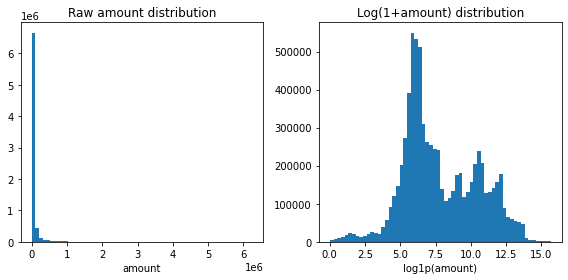

In [8]:
print('\nСтатистика по сумме транзакций:')
print(df['amount_usd'].describe())

# визуализируем распределение суммы (логарифмируем, т.к. часто сильно скошено)
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.hist(df['amount'].dropna(), bins=60)
plt.title('Raw amount distribution')
plt.xlabel('amount')

plt.subplot(1,2,2)
plt.hist(np.log1p(df['amount'].clip(lower=0)), bins=60)
plt.title('Log(1+amount) distribution')
plt.xlabel('log1p(amount)')
plt.tight_layout()
plt.show()

Общее количество транзакций: 7,483,766
Количество мошеннических транзакций: 1,494,719
Доля мошенничества (is_fraud==True): 0.1997 (19.97%)


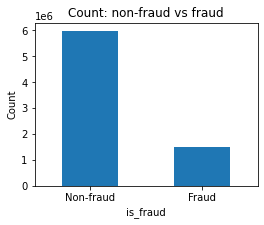

In [9]:
fraud_rate = df['is_fraud'].mean()
print(f"Общее количество транзакций: {len(df):,}")
print(f"Количество мошеннических транзакций: {df['is_fraud'].sum():,}")
print(f"Доля мошенничества (is_fraud==True): {fraud_rate:.4f} ({fraud_rate*100:.2f}%)")

# визуализация
plt.figure(figsize=(4,3))
counts = df['is_fraud'].value_counts()
counts.plot(kind='bar')
plt.title('Count: non-fraud vs fraud')
plt.xticks([0,1], ['Non-fraud', 'Fraud'], rotation=0)
plt.ylabel('Count')
plt.show()


In [10]:
# Fraud rate по основным категориальным признакам
cat_cols = ['vendor_category', 'vendor_type', 'country', 'city_size', 'card_type', 'channel', 'device', 'is_card_present', 'is_outside_home_country', 'is_high_risk_vendor']

def top_fraud_by(col, top_n=10, min_count=50):
    grp = df.groupby(col).agg(count=('is_fraud', 'size'), frauds=('is_fraud','sum'))
    grp['fraud_rate'] = grp['frauds'] / grp['count']
    grp = grp[grp['count'] >= min_count]
    return grp.sort_values('fraud_rate', ascending=False).head(top_n)


for c in cat_cols:
    if c in df.columns:
        print('\nTop fraud by', c)
        print(top_fraud_by(c, top_n=10, min_count=30))



Top fraud by vendor_category
                  count  frauds  fraud_rate
vendor_category                            
Travel           935790  187477    0.200341
Grocery          934029  186987    0.200194
Gas              935401  186829    0.199731
Restaurant       936178  186951    0.199696
Entertainment    936173  186890    0.199632
Education        933542  186203    0.199459
Retail           935883  186613    0.199398
Healthcare       936770  186769    0.199376

Top fraud by vendor_type
              count  frauds  fraud_rate
vendor_type                            
transport    233977   47069    0.201169
fast_food    312805   62786    0.200719
airlines     233476   46820    0.200535
physical     935039  187200    0.200206
booking      234026   46846    0.200174
events       312598   62525    0.200017
major        467499   93416    0.199821
pharmacy     468377   93569    0.199773
supplies     466765   93240    0.199758
local        467902   93413    0.199642

Top fraud by country
  

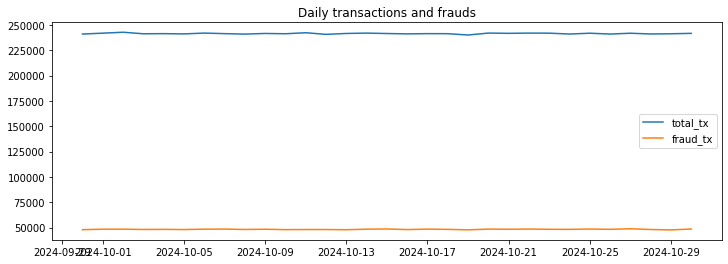

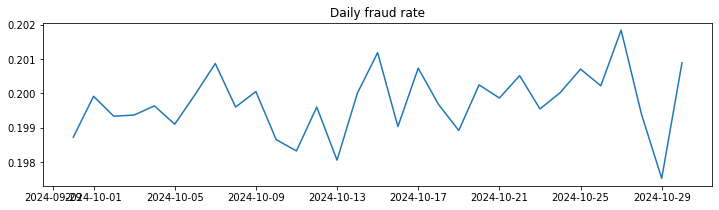

In [11]:

if 'tx_date' in df.columns:
    daily = df.groupby('tx_date').agg(total=('is_fraud','size'), frauds=('is_fraud','sum'))
    daily['fraud_rate'] = daily['frauds'] / daily['total']
    plt.figure(figsize=(12,4))
    plt.plot(daily.index, daily['total'], label='total_tx')
    plt.plot(daily.index, daily['frauds'], label='fraud_tx')
    plt.legend()
    plt.title('Daily transactions and frauds')
    plt.show()

    plt.figure(figsize=(12,3))
    plt.plot(daily.index, daily['fraud_rate'])
    plt.title('Daily fraud rate')
    plt.show()

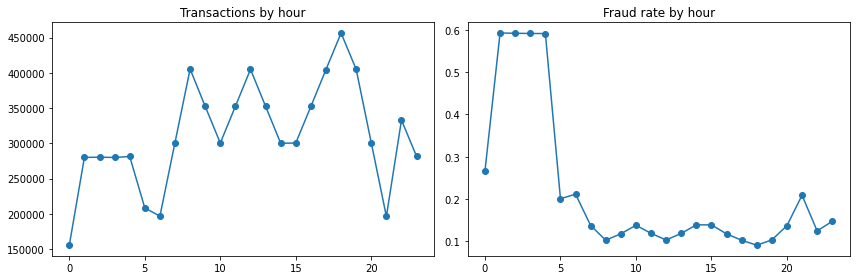

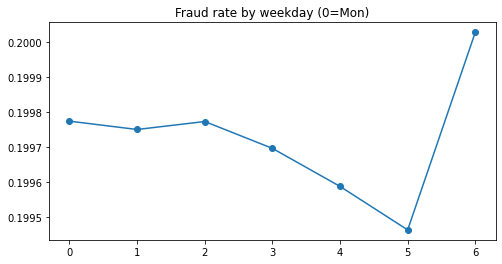

In [12]:
# Временные паттерны: час дня и день недели
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
hr = df.groupby('tx_hour').agg(total=('is_fraud','size'), frauds=('is_fraud','sum'))
hr['fraud_rate'] = hr['frauds']/hr['total']
plt.plot(hr.index, hr['total'], marker='o')
plt.title('Transactions by hour')

plt.subplot(1,2,2)
plt.plot(hr.index, hr['fraud_rate'], marker='o')
plt.title('Fraud rate by hour')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,4))
wd = df.groupby('tx_weekday').agg(total=('is_fraud','size'), frauds=('is_fraud','sum'))
wd['fraud_rate'] = wd['frauds']/wd['total']
plt.plot(wd.index, wd['fraud_rate'], marker='o')
plt.title('Fraud rate by weekday (0=Mon)')
plt.xticks(wd.index)
plt.show()

In [13]:
if 'country' in df.columns:
    ctab = df.groupby('country').agg(count=('is_fraud','size'), frauds=('is_fraud','sum'))
    ctab['fraud_rate'] = ctab['frauds']/ctab['count']
    display(ctab.sort_values('fraud_rate', ascending=False).head(10))
    

,count,frauds,fraud_rate
country,,,
Mexico,785704,298841,0.380348
Russia,793730,299425,0.377238
Brazil,804800,298629,0.371060
Nigeria,849840,298600,0.351360
Australia,496695,37652,0.075805
USA,500060,37312,0.074615
Japan,527393,37592,0.071279
Germany,524464,37205,0.070939
Canada,532632,37278,0.069988


In [14]:
if 'device' in df.columns and 'device_fingerprint' in df.columns:
    if 'customer_id' in df.columns:
        df['fp_per_customer'] = df.groupby('device_fingerprint')['customer_id'].transform('nunique')
        suspect_fp = df.groupby('device_fingerprint').agg(num_customers=('customer_id','nunique'), total_tx=('transaction_id','nunique'))
        suspect_fp = suspect_fp.sort_values('num_customers', ascending=False).head(10)
        print('\nTop device_fingerprints used by many customers:')
        display(suspect_fp)



Top device_fingerprints used by many customers:


,num_customers,total_tx
device_fingerprint,,
705065595f56ee279dedba7f4269d5b0,10,10
61cb6463141119abd41762825ad4f9cd,10,10
85cd1c1bf361609d72163ae6a979d987,10,10
5944cb714f20b1f0252ed4868883fa7f,10,10
ee850b8c0e95c7f0c1123449c605420e,10,10
6207f90da8beff9589e4e27ff1fddb53,10,10
86ac7968279b7c8f3d6fd7c3154c94e0,9,9
afef2a8f2e38312fed64f9a2c5717796,9,9
2d2074c881e43d8e336ef0c6e6a52cdc,9,9


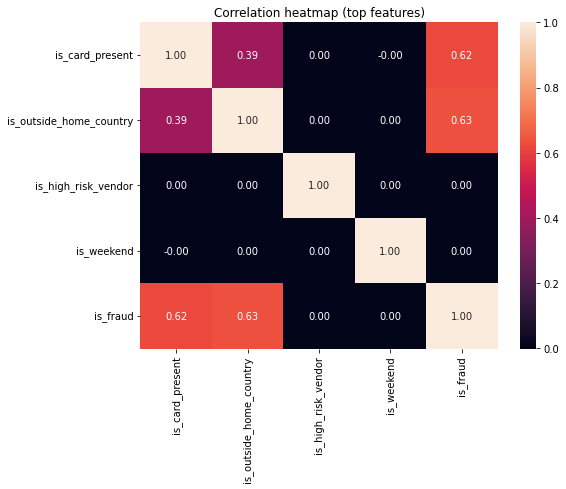

In [21]:
bool_cols = df.select_dtypes(include=['bool']).columns.tolist()

df_corr = df[bool_cols].astype(int)


corr = df_corr[bool_cols].corr()['is_fraud'].sort_values(ascending=False)

plt.figure(figsize=(8,6))
sns.heatmap(df_corr.corr(), annot=True, fmt='.2f')
plt.title('Correlation heatmap (top features)')
plt.show()